In [1]:
from discord.ext import commands
import discord
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime
from io import BytesIO
from flask import Flask, request
from threading import Thread
import json, os, sys, re
import pandas as pd
from thongke import generate_chart_pay_by_month, generate_chart_debt

scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive"
]


# sử dụng local
creds = ServiceAccountCredentials.from_json_keyfile_name(
    "credentials.json", scope)
client_gs = gspread.authorize(creds)
sheet = client_gs.open("chi_tieu_on_dinh").sheet1

data = sheet.get_all_values()



,NGÀY,HẠNG MỤC CHI,TIỀN,NGƯỜI CHI,NGƯỜI NHẬN,GHI CHÚ
0,2025-05-01 00:00:00,cơm tối,90000.0,Nghĩa,Phương Ngân,
1,2025-05-02 00:00:00,cơm tối,84000.0,Nghĩa,Mọi Người,
2,2025-05-03 00:00:00,cơm tối,20000.0,Nghĩa,Nhi,
3,2025-05-04 00:00:00,cơm tối,30000.0,Nghĩa,Đạt,
4,2025-05-05 00:00:00,nước suối,1410000.0,Phương,Mọi Người,
5,2025-05-06 00:00:00,phở,70000.0,Nhi,Phương Nghĩa,
6,2025-05-07 00:00:00,trà sữa,39000.0,Nhi,Ngân,
7,2025-05-08 00:00:00,cơm gà,30000.0,Nhi,Phương,
8,2025-05-09 00:00:00,chìa khoá,100000.0,Nhi,Mọi Người,
9,2025-05-10 00:00:00,trà tranh,50000.0,Nhi,Nghĩa Phương,


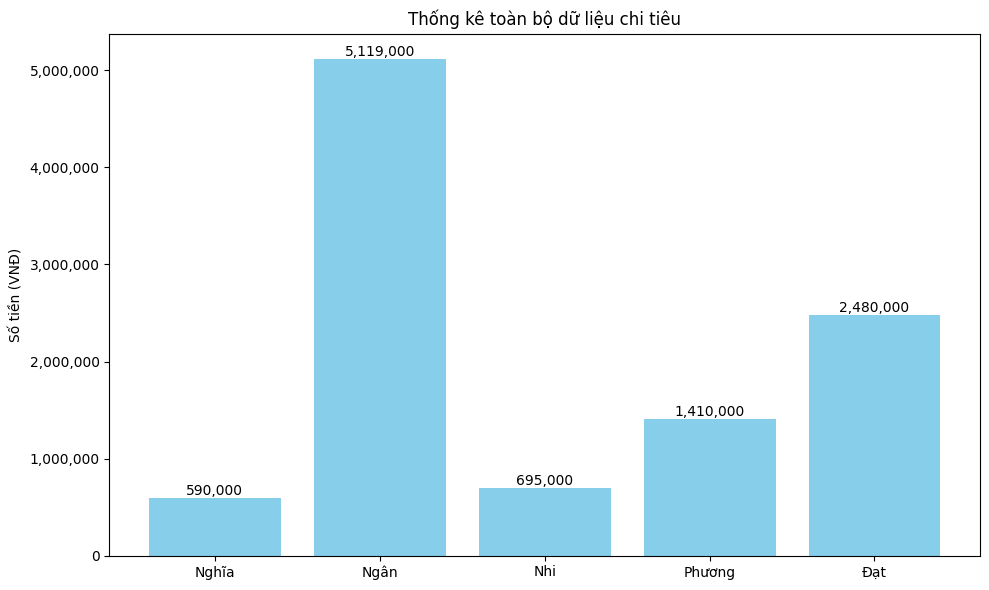

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df = pd.DataFrame(data[1:], columns=data[0])

# Làm sạch dữ liệu
df['NGÀY'] = pd.to_datetime(df['NGÀY'], errors='coerce', dayfirst=True)
df['TIỀN'] = df['TIỀN'].str.replace(r'[₫\s]', '',
                                    regex=True).str.replace(',',
                                                            '',
                                                            regex=False)
df['TIỀN'] = pd.to_numeric(df['TIỀN'], errors='coerce')
display(df)
df = df.dropna(subset=['NGÀY'])
time = None
if time:
    try:
        month, year = map(int, time.split('/'))
        if month < 1 or month > 12:
            print("Tháng không hợp lệ. Vui lòng nhập tháng từ 1 đến 12.")
            # return False
        df_filtered = df[(df['NGÀY'].dt.month == month)
                            & (df['NGÀY'].dt.year == year)]
    except Exception as e:
        print(f"Lỗi định dạng thời gian: {e}")
        # return False
else:

    df_filtered = df

# Thống kê
result = df_filtered.groupby('NGƯỜI CHI')['TIỀN'].sum().to_dict()
if not result:
    # return False
    pass

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bars = plt.bar(result.keys(), result.values(), color='skyblue')

plt.xlabel('')
plt.ylabel('Số tiền (VNĐ)')
try:
    plt.title(f"Thống kê chi tiêu tháng {month}/{year}")
except:
    plt.title("Thống kê toàn bộ dữ liệu chi tiêu")
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x):,}"))

for i, (name, value) in enumerate(result.items()):
    plt.text(i,
                value,
                f"{int(value):,}",
                ha='center',
                va='bottom',
                fontsize=10)

plt.tight_layout()

plt.show()
# buf = BytesIO()
# plt.savefig(buf, format='png')
# buf.seek(0)
# plt.close()

In [14]:
import knowledge
import json
import re

with open("slang_mapping.json", "r", encoding="utf-8") as f:
    slang_mapping = json.load(f)
    slang_mapping = {k.strip().lower(): v for k, v in slang_mapping.items()}


import json
import re

with open("slang_mapping.json", "r", encoding="utf-8") as f:
    slang_mapping = json.load(f)

# Normalize key
slang_mapping = {k.strip().lower(): v for k, v in slang_mapping.items()}

def parse_amount(amount_text, slang_mapping):
    if not amount_text:
        return 0, None

    amt_text = amount_text.lower().replace(",", "").replace(" ", "").strip()
    print(amt_text)
    total_amount = 0

    pattern = r"(\d+(?:\.\d+)?)([a-zA-ZÀ-Ỹà-ỹ]*)"  # thêm support tiếng Việt có dấu
    matches = re.findall(pattern, amt_text)
    print(matches)

    last_unit = None
    for number_part, unit_part in matches:
        try:
            base_amount = float(number_part)
        except:
            base_amount = 0

        unit_part = unit_part.strip().lower()

        if unit_part:
            if unit_part not in slang_mapping:
                return 0, f"❌ Đơn vị `{unit_part}` chưa có trong slang. Vui lòng thêm bằng lệnh `bot ngu: {unit_part} = giá trị`."
            multiplier = slang_mapping[unit_part]
            total_amount += int(base_amount * multiplier)
            last_unit = unit_part
        else:
            if last_unit and last_unit in slang_mapping:
                next_step = slang_mapping[last_unit] / 10
                total_amount += int(base_amount * next_step)
            else:
                total_amount += int(base_amount)

    return total_amount, None

print(parse_amount('2tr2', slang_mapping))

2tr2
[('2', 'tr'), ('2', '')]
(2200000, None)


In [4]:
def replace_slang(text, mapping):
    for slang, real_name in mapping.items():
        text = text.replace(slang, str(real_name))
    return text

text = 'anh Đạt, nợ cũ, 2tr480k, nghĩa'

content = text.split(",")
content = [c.strip() for c in content]
print(content[0])
a = replace_slang(content[0].lower(), slang_mapping)
print(a)

anh Đạt
Đạt


In [6]:
sheet_slang_mapping = client_gs.open("chi_tieu_on_dinh").worksheet('slang_mapping')
def load_slang_from_sheet(slang_sheet):
    rows = slang_sheet.get_all_records()
    slang_mapping = {}

    for row in rows:
        key = row['slang'].strip().lower()
        type_ = row['type']
        value_raw = row['value']

        if type_ == "number":
            value = float(value_raw)
        elif type_ == "list":
            value = [v.strip() for v in value_raw.split(",")]
        else:
            value = value_raw

        slang_mapping[key] = value

    return slang_mapping

def replace_slang(text, mapping):
    # Sắp xếp slang theo độ dài giảm dần để replace từ dài trước
    sorted_mapping = sorted(mapping.items(), key=lambda x: len(x[0]), reverse=True)
    
    for slang, real_value in sorted_mapping:
        text = text.replace(slang, str(real_value))
    return text


def update_slang_mapping_to_sheet(message_content, sheet_slang_mapping):
    # Regex tách dạng "bot ngu: something = something"
    pattern = r"bot ngu:\s*(.+?)\s*=\s*(.+)"
    match = re.match(pattern, message_content, re.IGNORECASE)

    if match:
        key = match.group(1).strip()
        value_raw = match.group(2).strip()

        # Xác định kiểu dữ liệu của value
        try:
            value = int(value_raw.replace(",", "").replace(".", ""))
            type_ = "number"
        except ValueError:
            # Nếu nhập value là list cách nhau bằng dấu ,
            if "," in value_raw:
                value = [v.strip() for v in value_raw.split(",")]
                type_ = "list"
                value_raw = ",".join(value)  # để lưu lên sheet
            else:
                value = value_raw
                type_ = "string"

        # Kiểm tra xem key đã tồn tại chưa
        rows = sheet_slang_mapping.get_all_records()
        for i, row in enumerate(rows):
            if row['slang'] == key:
                sheet_slang_mapping.update_cell(i+2, 2, type_)
                sheet_slang_mapping.update_cell(i+2, 3, value_raw)
                return f"Đã cập nhật: '{key}' → '{value_raw}'"

        # Nếu chưa có thì thêm mới
        sheet_slang_mapping.append_row([key, type_, value_raw])
        return f"Đã thêm mới: '{key}' → '{value_raw}'"
    else:
        return "Cú pháp sai rồi bro! Dùng đúng dạng: bot ngu: cái này = cái kia"
    


slang_mapping = load_slang_from_sheet(sheet_slang_mapping)
text = 'chị ngân, đi chợ, 100k, Chị Ngân'

print(slang_mapping)
print(replace_slang(text.split(",")[3].lower(), slang_mapping))

{'chị ngân': 'Ngân', 'k': 1000.0, 'tr': 1000000.0, 'tỷ': 1000000000.0, 'mn': 'mọi người', 'harmonious_fox_17849': 'Nghĩa', 'doufang_8': 'Phương', 'anh phương': 'Phương', 'ann_nguyen123': 'Ngân'}
 Ngân
